Cell lines are a bit of a mess, especially CCLE, since it doesn't have stable identifiers. This notebook uses PyOBO to assess if and to what extent mapping away from CCLE is possible.

In [1]:
import getpass
import itertools as itt
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import pyobo
import seaborn as sns
from pyobo.utils.io import write_map_tsv

In [2]:
print(sys.version)

3.9.5 (default, May  4 2021, 03:36:27) 
[Clang 12.0.0 (clang-1200.0.32.29)]


In [3]:
print(time.asctime())

Thu Jul  8 10:06:06 2021


In [4]:
print(getpass.getuser())

cthoyt


In [5]:
print(pyobo.get_version())

0.5.1-dev


In [6]:
prefixes = sorted([
    'ccle.cell',
    'cellosaurus',
    'efo',
    # 'clo',
    'cl',
    'depmap',
    'bto',
])

In [7]:
prefix_to_identifiers = {}
for prefix in prefixes:
    try:
        prefix_to_identifiers[prefix] = pyobo.get_ids(prefix, strict=False)
    except Exception:
        continue

In [8]:
mappings = {}

for p1, p2 in itt.product(prefix_to_identifiers, repeat=2):
    if p1 == p2:
        continue
    mappings[p1, p2] = pyobo.get_filtered_xrefs(p1, p2)

In [9]:
data = pd.DataFrame(columns=['from_prefix', 'to_prefix', 'n'], data=[
    (from_prefix, to_prefix, len(m))
    for (from_prefix, to_prefix), m in mappings.items()
]).pivot('from_prefix', 'to_prefix').fillna(0.0).astype(int)
data

n                                      
to_prefix     bto ccle.cell cellosaurus cl depmap   efo
from_prefix                                            
bto             0         0           0  0      0     0
ccle.cell       0         0           0  0   1457     0
cellosaurus  2352         0           0  0   1788  1296
cl            254         0           0  0      0     1
depmap          0         0        1678  0      0     0
efo            63         0           0  2      0     0

<AxesSubplot:xlabel='None-to_prefix', ylabel='from_prefix'>

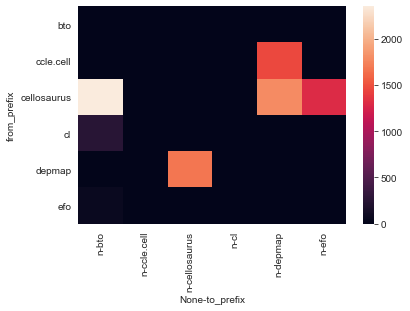

In [10]:
sns.set_style('whitegrid')
sns.heatmap(data)
plt.show()

In [11]:
def cdict(x):
    return {k:v for k,v in x if v}

In [12]:
ccle_depmap = pyobo.get_filtered_xrefs('ccle', 'depmap')
print('Got', len(ccle_depmap), 'mappings from CCLE to DepMap')

Got 1457 mappings from CCLE to DepMap


In [13]:
ccle_cellosaurus = cdict(
    (ccle_id, pyobo.get_xref('depmap', depmap_id, 'cellosaurus'))
    for ccle_id, depmap_id in ccle_depmap.items()
)
print('Got', len(ccle_cellosaurus), 'mappings from CCLE to Cellosaurus (via DepMap)')

Got 1444 mappings from CCLE to Cellosaurus (via DepMap)


In [14]:
ccle_efo = cdict(
    (ccle_id, pyobo.get_xref('cellosaurus', cvcl_id, 'efo'))
    for ccle_id, cvcl_id in ccle_cellosaurus.items()
)
print('Got', len(ccle_efo), 'mappings from CCLE to EFO (via DepMap then Cellosaurus)')

Got 714 mappings from CCLE to EFO (via DepMap then Cellosaurus)


In [15]:
ccle_bto = cdict(
    (ccle_id, pyobo.get_xref('cellosaurus', cvcl_id, 'bto'))
    for ccle_id, cvcl_id in ccle_cellosaurus.items()
)
print('Got', len(ccle_bto), 'mappings from CCLE to Brenda Tissue Ontology (via DepMap then Cellosaurus)')

Got 595 mappings from CCLE to Brenda Tissue Ontology (via DepMap then Cellosaurus)


In [16]:
write_map_tsv(path='ccle_depmap.tsv', header=['ccle', 'depmap'], rv=ccle_depmap)
write_map_tsv(path='ccle_cellosaurus.tsv', header=['ccle', 'cellosaurus'], rv=ccle_cellosaurus)
write_map_tsv(path='ccle_efo.tsv', header=['ccle', 'efo'], rv=ccle_efo)
write_map_tsv(path='ccle_bto.tsv', header=['ccle', 'bto'], rv=ccle_bto)